In [4]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

from lets_plot import *
LetsPlot.setup_html()

In [10]:
enso = pl.read_parquet('../data/2_inter/enso_interpolated.parquet')[['date','enso','iod','pdo']]
data = pl.read_parquet('../../ds-spatiotemporal-mosqlimate/data/03_primary/dataset_complete_dengue_uf.parquet')
data = data.filter(pl.col('uf') != 'ES')
data = data.drop(['enso','iod','pdo'])

data = data.with_columns(
    pl.col("date").dt.date().alias("date")
)

data = data.join(enso, on="date", how="left").sort(['uf','date'])
data = data.rename({'casos': 'target'})
data = data.with_columns(
    np.log1p(pl.col("target")).alias("log_casos")
)

In [11]:
static_features = data.group_by('uf').agg(pl.col('uf_latitude').first(),pl.col('uf_longitude').first())
# static_features = static_features.rename({'uf':'item_id'}).to_pandas()
# static_features = static_features.to_pandas()

In [7]:
# exo = ['enso','uf_latitude','uf_longitude','log_casos']
exo = ['enso','log_casos']
train_1 = data.filter(pl.col('train_1'))[['uf','date','target',*exo]]
train_1 = TimeSeriesDataFrame.from_data_frame(
    train_1.to_pandas(),id_column='uf',
    timestamp_column='date',
    static_features_df=static_features.to_pandas()
)
test_1 =  data.filter(
    pl.col('target_1') | (
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_1')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1.to_pandas(),id_column='uf',timestamp_column='date',static_features_df=static_features.to_pandas())

In [ ]:
prediction_length = 68
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_1,
    hyperparameters={
        "Chronos": [
            # {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            # {"model_path": "bolt_small",
            #  "covariate_regressor": "CAT",
            #  "target_scaler": "standard",
            #  "fine_tune": True,
            #  "ag_args": {"name_suffix": "FineTuned-Covariates"}},
        ]
    },
    # time_limit=60,  # time limit in seconds
    # enable_ensemble=False,
    # presets='fast_training'
    # presets='medium_quality'
    # presets='high_quality'
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/jbd-mosqlimate-sprint/notebooks/AutogluonModels/ag-20250731_030027'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          1
Memory Avail:       3.92 GB / 16.00 GB (24.5%)
Disk Space Avail:   378.06 GB / 926.35 GB (40.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 68,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6

In [12]:
#past_covariates:
# 	categorical:        []
# 	continuous (float): ['enso', 'log_casos', 'iod', 'pdo']
# static_features:
# 	categorical:        []
# 	continuous (float): ['uf_latitude', 'uf_longitude']
# chronos_small

predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.582592,-0.694272,1.442673,0.992182,402.964164,1


In [ ]:
#past_covariates:
# 	categorical:        []
# 	continuous (float): ['enso', 'log_casos', 'iod', 'pdo']
# static_features:
# 	categorical:        []
# 	continuous (float): ['uf_latitude', 'uf_longitude']
# chronos_base

predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.582592,-0.694272,1.634411,0.835767,406.976061,1


In [95]:
# chronos_base
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_base],-0.724377,-0.620088,4.701164,3.350112,1830.23442,1


In [90]:
# autoarima
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,AutoARIMA,-0.983466,-0.906101,1.161617,4.859897,0.010297,1


In [88]:
# high_quality
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.528746,-0.526720,0.100574,0.068165,0.378558,13
1,TiDE,-0.537627,-0.563243,0.049973,0.030612,112.521254,12
2,TemporalFusionTransformer,-0.568370,-0.588757,0.049528,0.037553,168.373415,9
3,ChronosFineTuned[bolt_small],-0.577477,-0.691830,1.539086,1.043067,387.288835,8
4,DirectTabular,-0.577946,-0.631954,0.058130,0.036503,9.558332,3
5,ChronosZeroShot[bolt_base],-0.580854,-0.607626,5.771958,14.994655,0.007783,7
6,DeepAR,-0.629080,-0.667602,0.597898,0.689800,302.013221,10
7,PatchTST,-0.695795,-0.635757,0.030963,0.023771,16.982375,11
8,NPTS,-0.784417,-0.778217,0.480468,0.461577,0.012397,4
9,RecursiveTabular,-0.954213,-0.798214,0.088260,0.081145,1.285629,2


In [85]:
# medium_quality
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer,-0.497160,-0.585695,0.044724,0.036434,161.357629,8
1,WeightedEnsemble,-0.504467,-0.581803,0.295566,0.272518,0.339651,9
2,Chronos[bolt_small],-0.570180,-0.656624,1.977698,2.412315,0.007251,7
3,DirectTabular,-0.577946,-0.631954,0.074712,0.042480,7.715247,4
4,RecursiveTabular,-0.954213,-0.798214,0.089165,0.152594,0.985073,3
5,SeasonalNaive,-1.050353,-0.874820,0.026415,0.029090,0.008248,2
6,Naive,-1.050353,-0.874820,0.030435,0.044935,0.013699,1
7,Theta,-1.054638,-0.903101,0.101869,0.095393,0.009168,6
8,ETS,-1.508780,-1.079030,0.175252,0.193604,0.011997,5


In [83]:
# fast_training
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DirectTabular,-0.577946,-0.631954,0.079287,0.042481,7.926817,4
1,WeightedEnsemble,-0.582768,-0.628363,0.181596,0.208628,0.373478,7
2,RecursiveTabular,-0.954213,-0.798214,0.101718,0.166147,0.974958,3
3,SeasonalNaive,-1.050353,-0.874820,0.026788,0.016988,0.008585,2
4,Naive,-1.050353,-0.874820,0.032205,4.047493,0.015905,1
5,Theta,-1.054638,-0.903101,0.100560,0.108487,0.015899,6
6,ETS,-1.508780,-1.079030,0.196388,6.489339,0.012320,5


In [81]:
# exo = ['enso','log_casos']
# static_features = ['uf_latitude','uf_longitude']
# sem ES
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.515345,-0.657412,1.68264,0.886013,47.210511,2
1,ChronosZeroShot[bolt_small],-0.570180,-0.656624,2.27465,2.512505,0.012778,1


In [76]:
# exo = ['enso','log_casos']
# static_features = ['uf_latitude','uf_longitude']
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.520432,-0.647692,1.768481,1.203778,47.572471,2
1,ChronosZeroShot[bolt_small],-0.600741,-0.662158,2.033649,2.191803,0.013979,1


In [73]:
# exo = ['enso']
# static_features = ['uf_latitude','uf_longitude']
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.528124,-0.647579,1.803955,1.119993,47.409658,2
1,ChronosZeroShot[bolt_small],-0.600741,-0.662158,2.269414,2.466186,0.008526,1


In [21]:
# exo = ['enso']
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.535457,-0.648518,1.291525,1.130829,47.948555,2
1,ChronosZeroShot[bolt_small],-0.600741,-0.662158,1.874855,1.976688,0.011595,1


In [17]:
# exo = ['enso','uf_latitude','uf_longitude']
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.528124,-0.647579,1.322837,0.922529,48.234048,2
1,ChronosZeroShot[bolt_small],-0.600741,-0.662158,1.883153,1.943558,0.018558,1


In [10]:
# No exo
# exo = []
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.538200,-0.648768,1.242649,0.916570,47.602783,2
1,ChronosZeroShot[bolt_small],-0.600741,-0.662158,1.961175,2.228924,0.007869,1


In [6]:
# exo = ['enso','uf_latitude','uf_longitude','log_casos']
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.521569,-0.647455,1.727843,0.933005,45.460957,2
1,ChronosZeroShot[bolt_small],-0.600741,-0.662158,1.870544,2.236477,1.530259,1


In [91]:
predictions = predictor.predict(train_1)

Model not specified in predict, will default to the model with the best validation score: AutoARIMA


data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


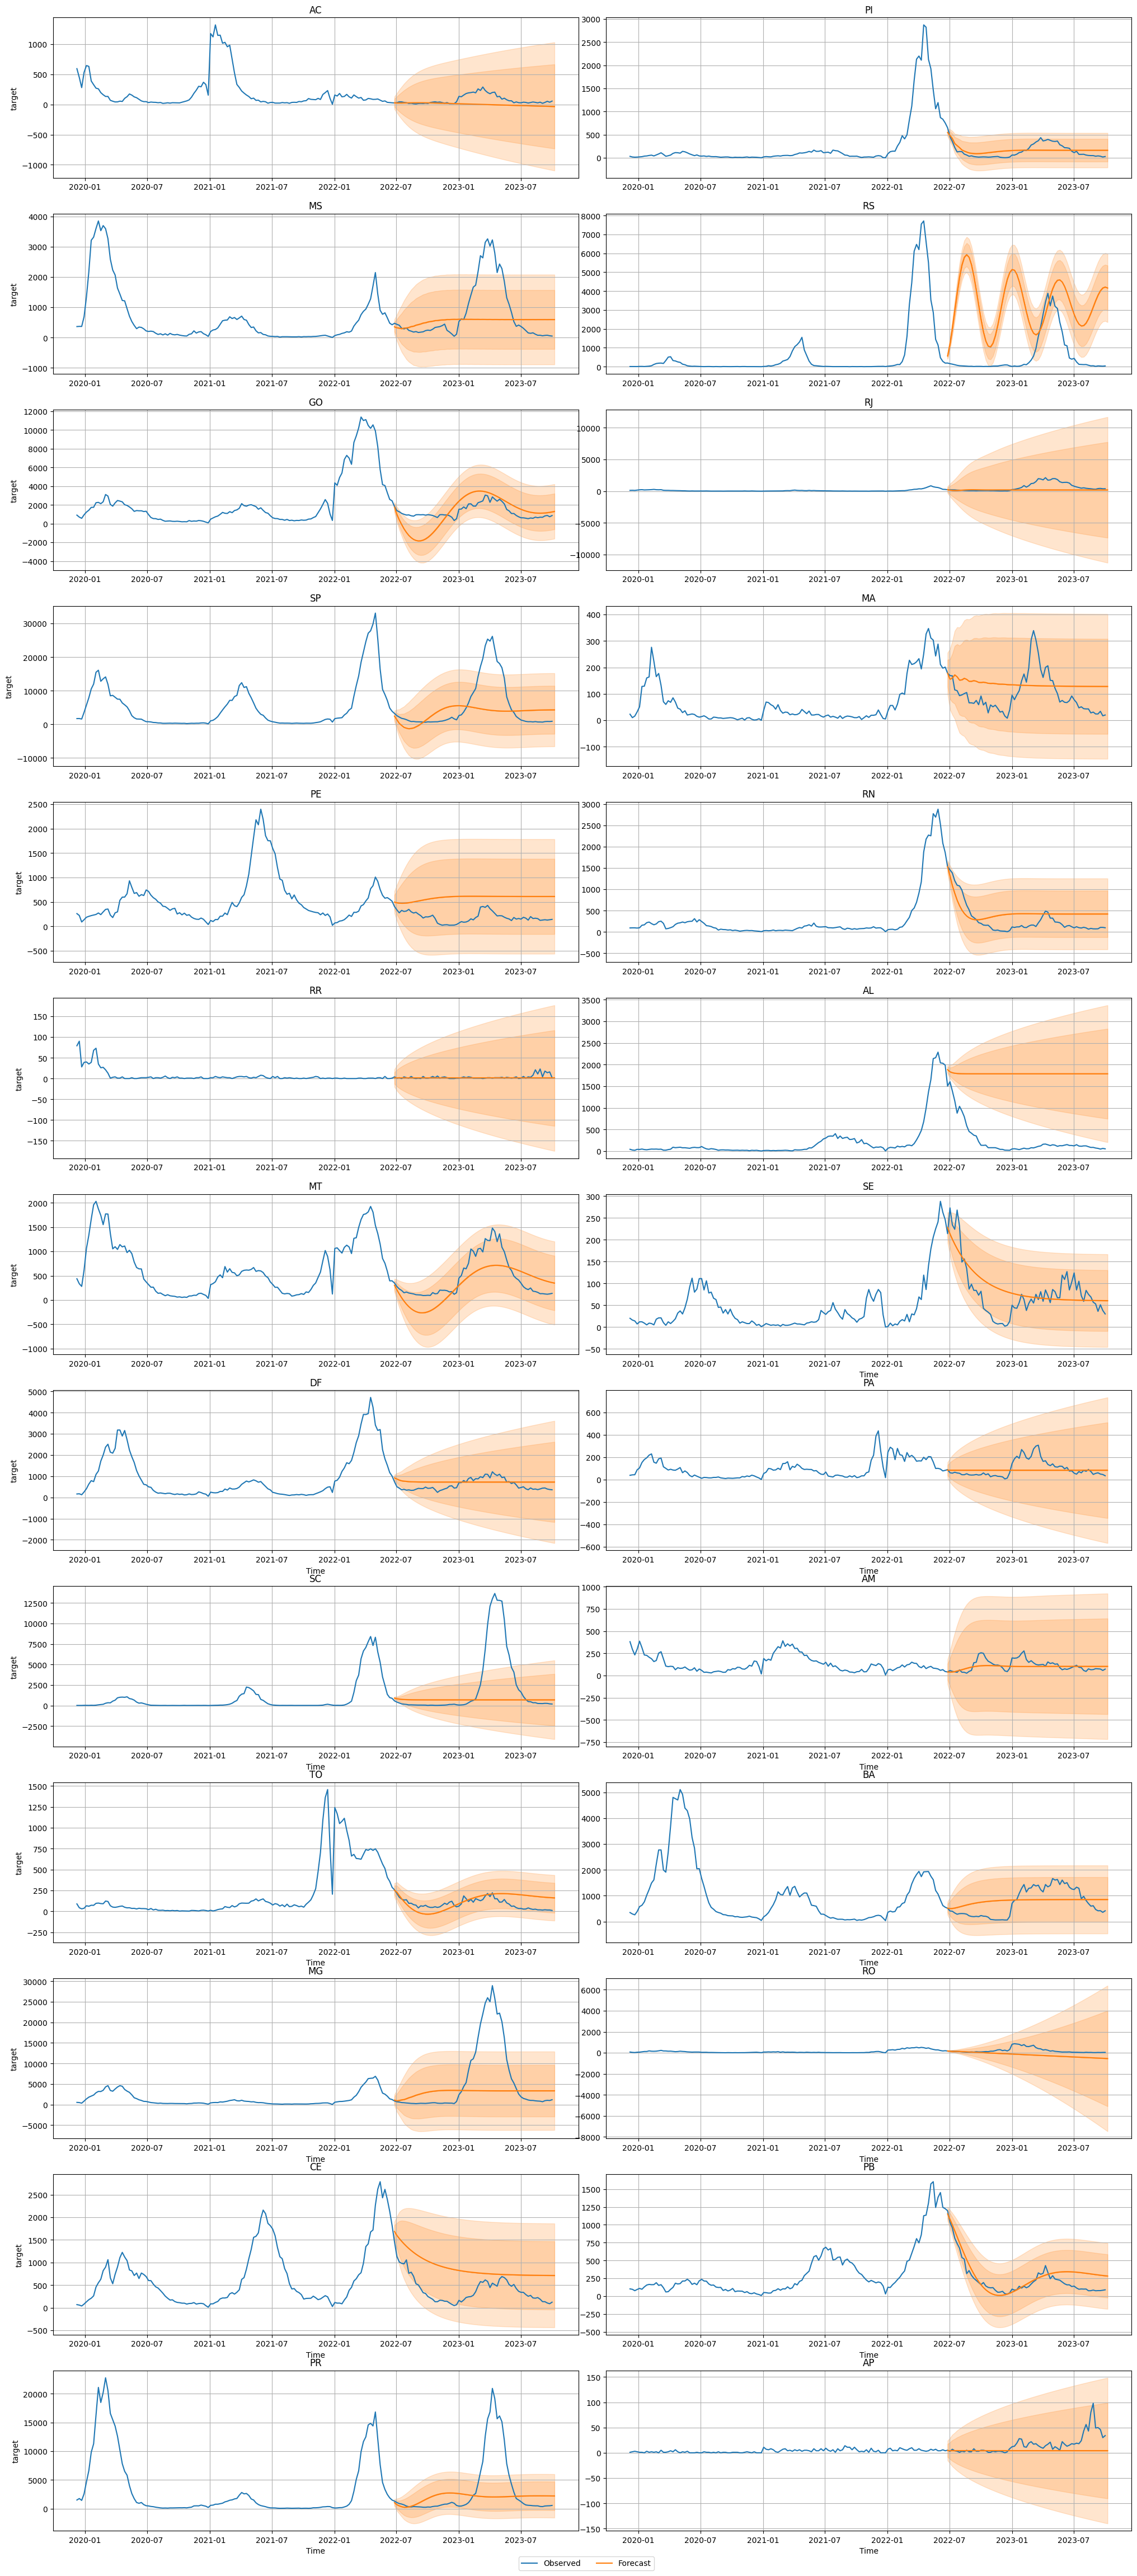

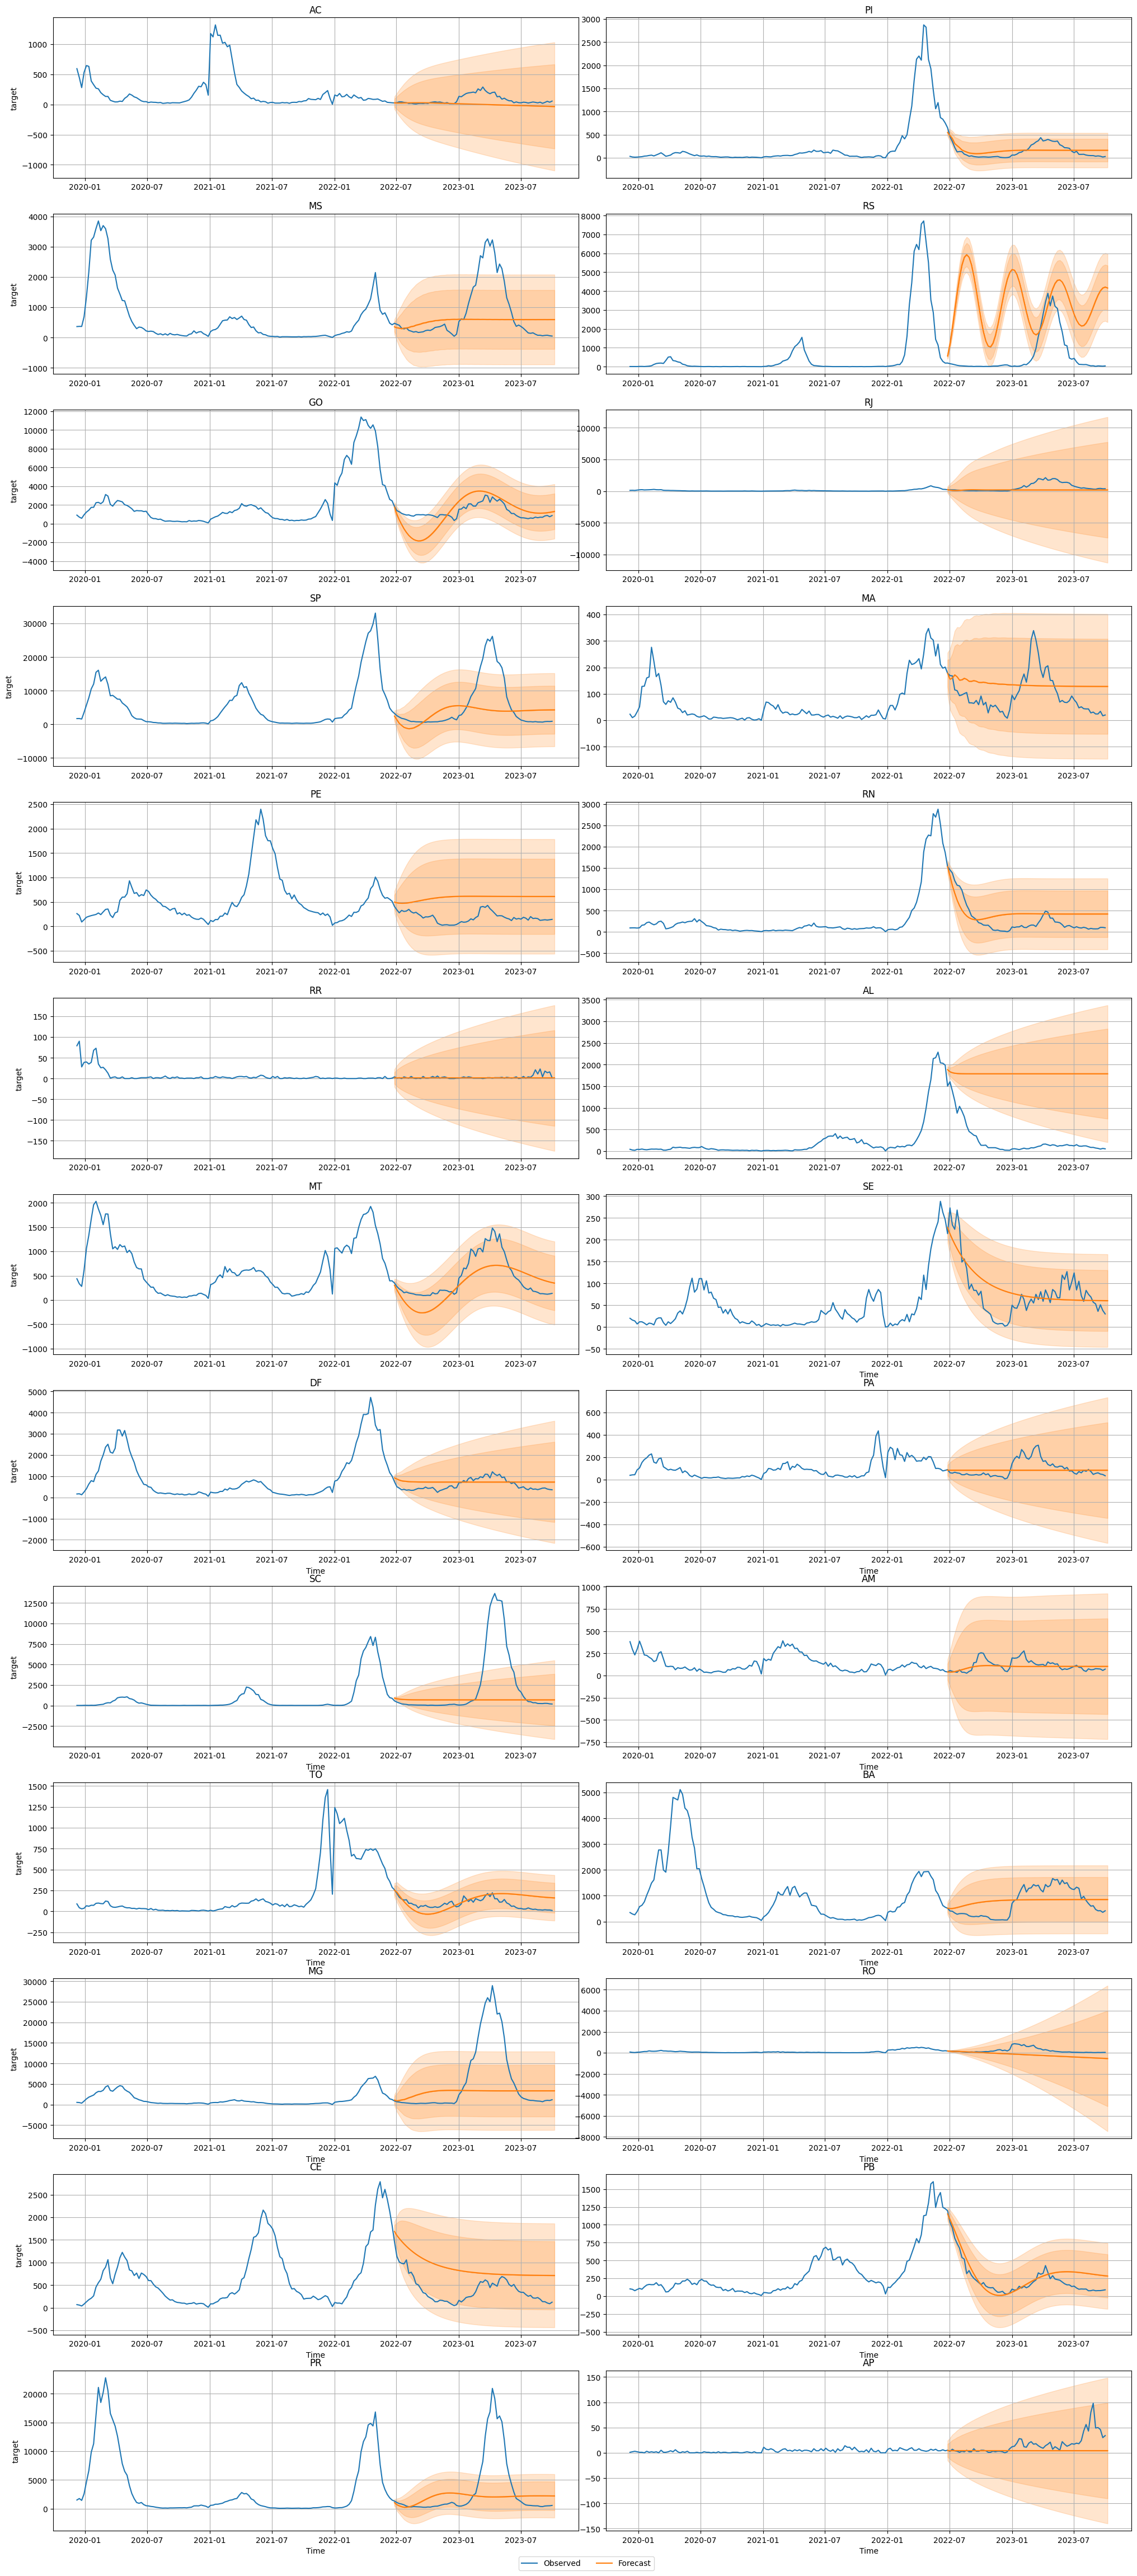

In [92]:
ufs = data['uf'].unique()
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    # quantile_levels=[0.05,0.1,0.5,0.9,0.95],
    # quantile_levels= QS,
    predictions=predictions,
    # item_ids=['CE'],
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=200,
)